In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import qdatoolkit as qda

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

t       x       y     z  layer_id  sensor0  sensor1    temp  \
0  127875690.0  38.119 -54.480  8.96       224    800.0    805.0  1580.9   
1  127875700.0  38.118 -54.489  8.96       224    807.0    801.0  1596.0   
2  127875710.0  38.119 -54.498  8.96       224    813.0    809.0  1593.2   
3  127875720.0  38.119 -54.508  8.96       224    813.0    824.0  1573.0   
4  127875730.0  38.121 -54.515  8.96       224    820.0    825.0  1581.0   

   track_id  track_orient  pos_rel  t_rel  
0         0           271  0.00000    0.0  
1         0           271  0.00721   10.0  
2         0           271  0.01442   20.0  
3         0           271  0.02163   30.0  
4         0           271  0.02884   40.0

In [2]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [3]:
digits_round = 1
x_range = (26.264, 38.053)
y_range = (-66.506, -54.848)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df,layer_ids, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_11076\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_11076\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming list_25l is a numpy array of shape (25, 120, 118)
num_layers = list_25l.shape[0]
height = list_25l.shape[1]
width = list_25l.shape[2]
smallest_cluster_pixels = []
biggest_cluster_pixels = []

for i in range(num_layers):
    # Extract the current layer
    current_layer = list_25l[i, :, :]

    # Standardize the data before reshaping for PCA
    scaler_pca = StandardScaler()
    current_layer_scaled = scaler_pca.fit_transform(current_layer)

    # Reshape the standardized data for PCA
    X = current_layer_scaled.reshape(-1, 1)

    # Apply PCA
    pca = PCA(n_components=1)
    scores = pca.fit_transform(X)

    # Compute Hotelling’s T² statistic for each pixel
    explained_variance = pca.explained_variance_
    if explained_variance[0] > 1e-8:
        T2 = (scores ** 2) / explained_variance[0]
    else:
        T2 = np.zeros_like(scores)

    # Standardize T2 values before K-means (optional but potentially useful)
    scaler_kmeans = StandardScaler()
    T2_scaled = scaler_kmeans.fit_transform(T2.reshape(-1, 1))

    # Apply K-means clustering on the T² map
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    clusters_flat = kmeans.fit_predict(T2_scaled)
    clusters_map = clusters_flat.reshape(height, width)

    # Calculate the size of each cluster
    unique_clusters, counts = np.unique(clusters_map, return_counts=True)
    cluster_sizes = dict(zip(unique_clusters, counts))

    # Find the label of the smallest and biggest cluster
    smallest_cluster_label = min(cluster_sizes, key=cluster_sizes.get)
    biggest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)

    # Extract the pixel coordinates and values for the smallest cluster
    smallest_cluster_indices = np.where(clusters_map == smallest_cluster_label)
    smallest_cluster_coords = list(zip(smallest_cluster_indices[0], smallest_cluster_indices[1]))
    smallest_cluster_values = current_layer_scaled[smallest_cluster_indices]
    smallest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": smallest_cluster_label,
        "pixel_coordinates": smallest_cluster_coords,
        "pixel_values": smallest_cluster_values
    })

    # Extract the pixel coordinates and values for the biggest cluster
    biggest_cluster_indices = np.where(clusters_map == biggest_cluster_label)
    biggest_cluster_coords = list(zip(biggest_cluster_indices[0], biggest_cluster_indices[1]))
    biggest_cluster_values = current_layer_scaled[biggest_cluster_indices]
    biggest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": biggest_cluster_label,
        "pixel_coordinates": biggest_cluster_coords,
        "pixel_values": biggest_cluster_values
    })

In [5]:
# Iterate through each layer's smallest cluster data
data = []
for layer_data in smallest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        data.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
high_T2_cluster = pd.DataFrame(data)
high_T2_cluster.head()

x  y  temp_std  layer_id
0  0  0  2.732935         1
1  2  0  2.486629         1
2  4  0  2.301647         1
3  6  0  3.156023         1
4  7  0  1.891568         1

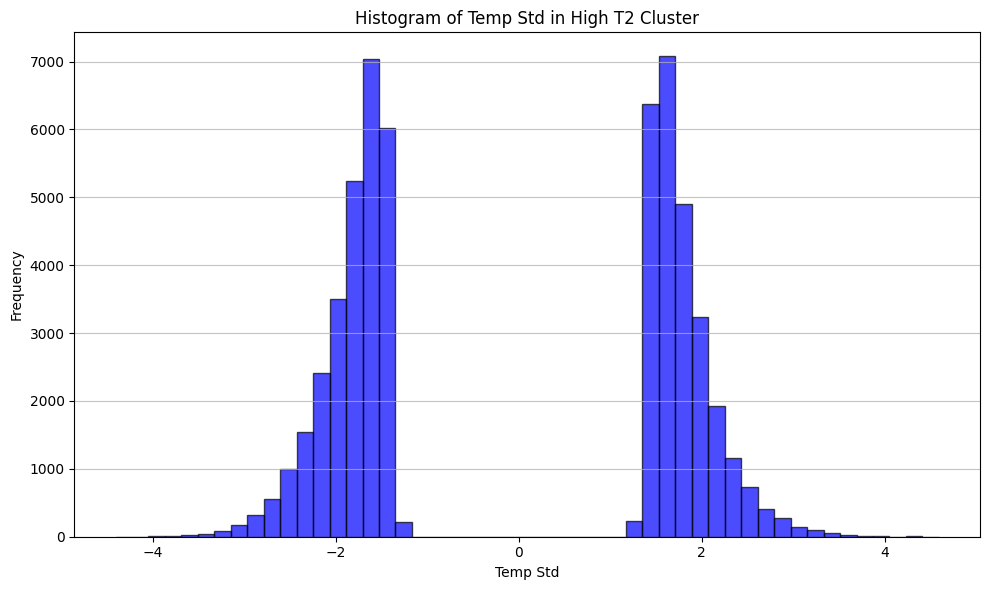

In [6]:
# Create a histogram of 'temp_std'
plt.figure(figsize=(10, 6))
plt.hist(high_T2_cluster['temp_std'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Temp Std')
plt.ylabel('Frequency')
plt.title('Histogram of Temp Std in High T2 Cluster')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [7]:
# Separate into cold_spots and hot_spots based on temp_std threshold
cold_spots = high_T2_cluster[high_T2_cluster['temp_std'] < 0].copy()
hot_spots = high_T2_cluster[high_T2_cluster['temp_std'] >= 0].copy()

# Reset indices for both DataFrames
cold_spots.reset_index(drop=True, inplace=True)
hot_spots.reset_index(drop=True, inplace=True)


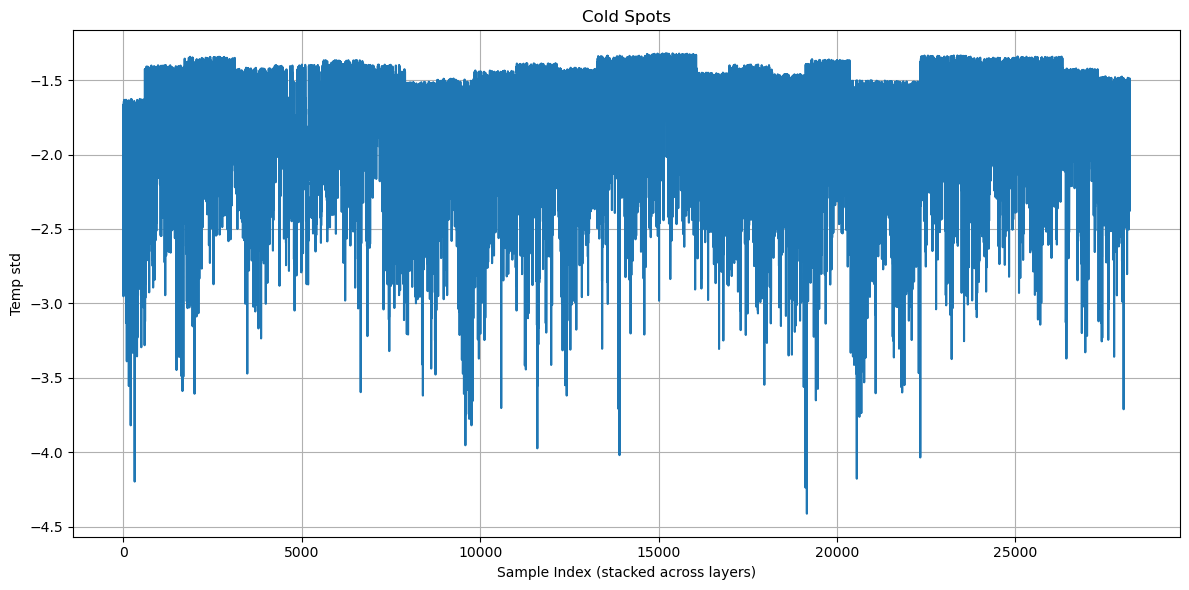

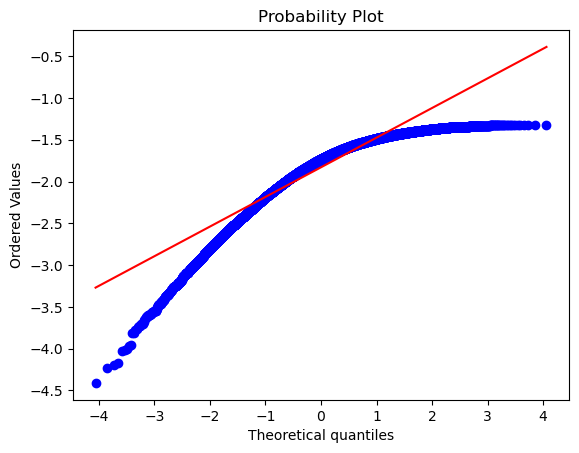

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.897
Shapiro-wilk test p-value = 0.000
Runs test statistic = -36.415
Runs test p-value = 0.000



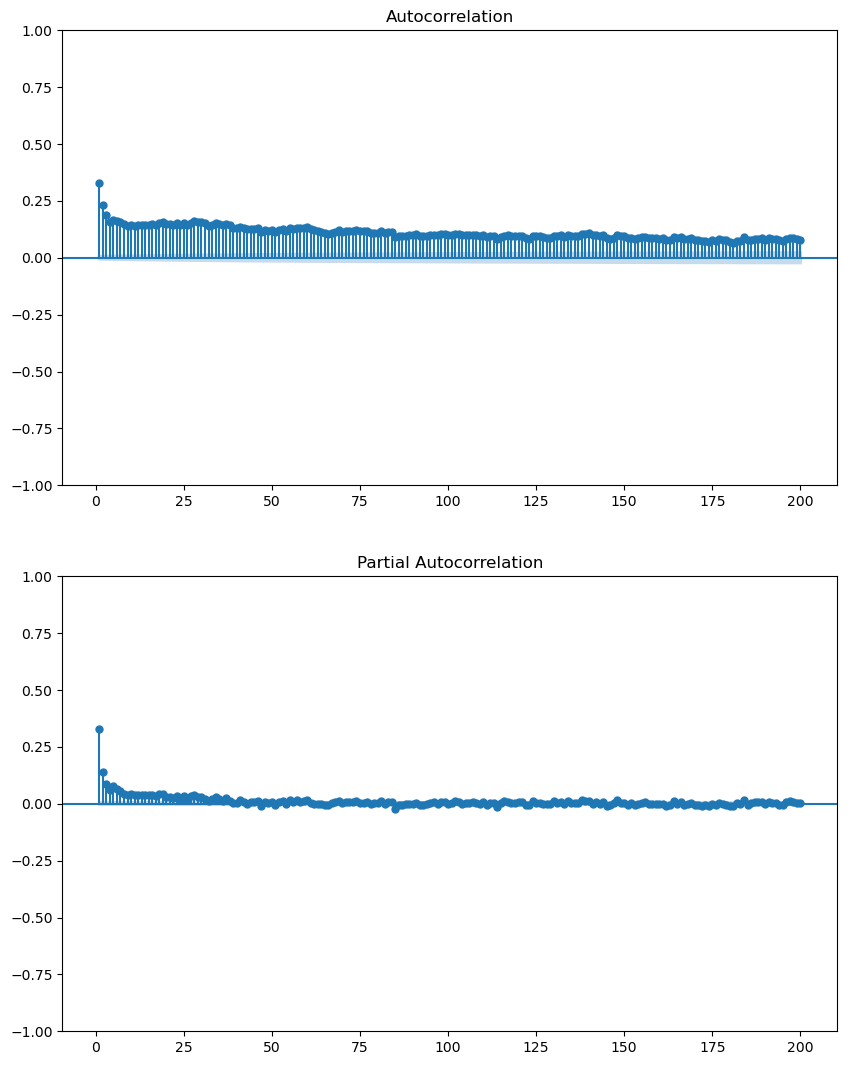

In [8]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(cold_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Cold Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(cold_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(cold_spots['temp_std']).independence()  # Controllo di indipendenza

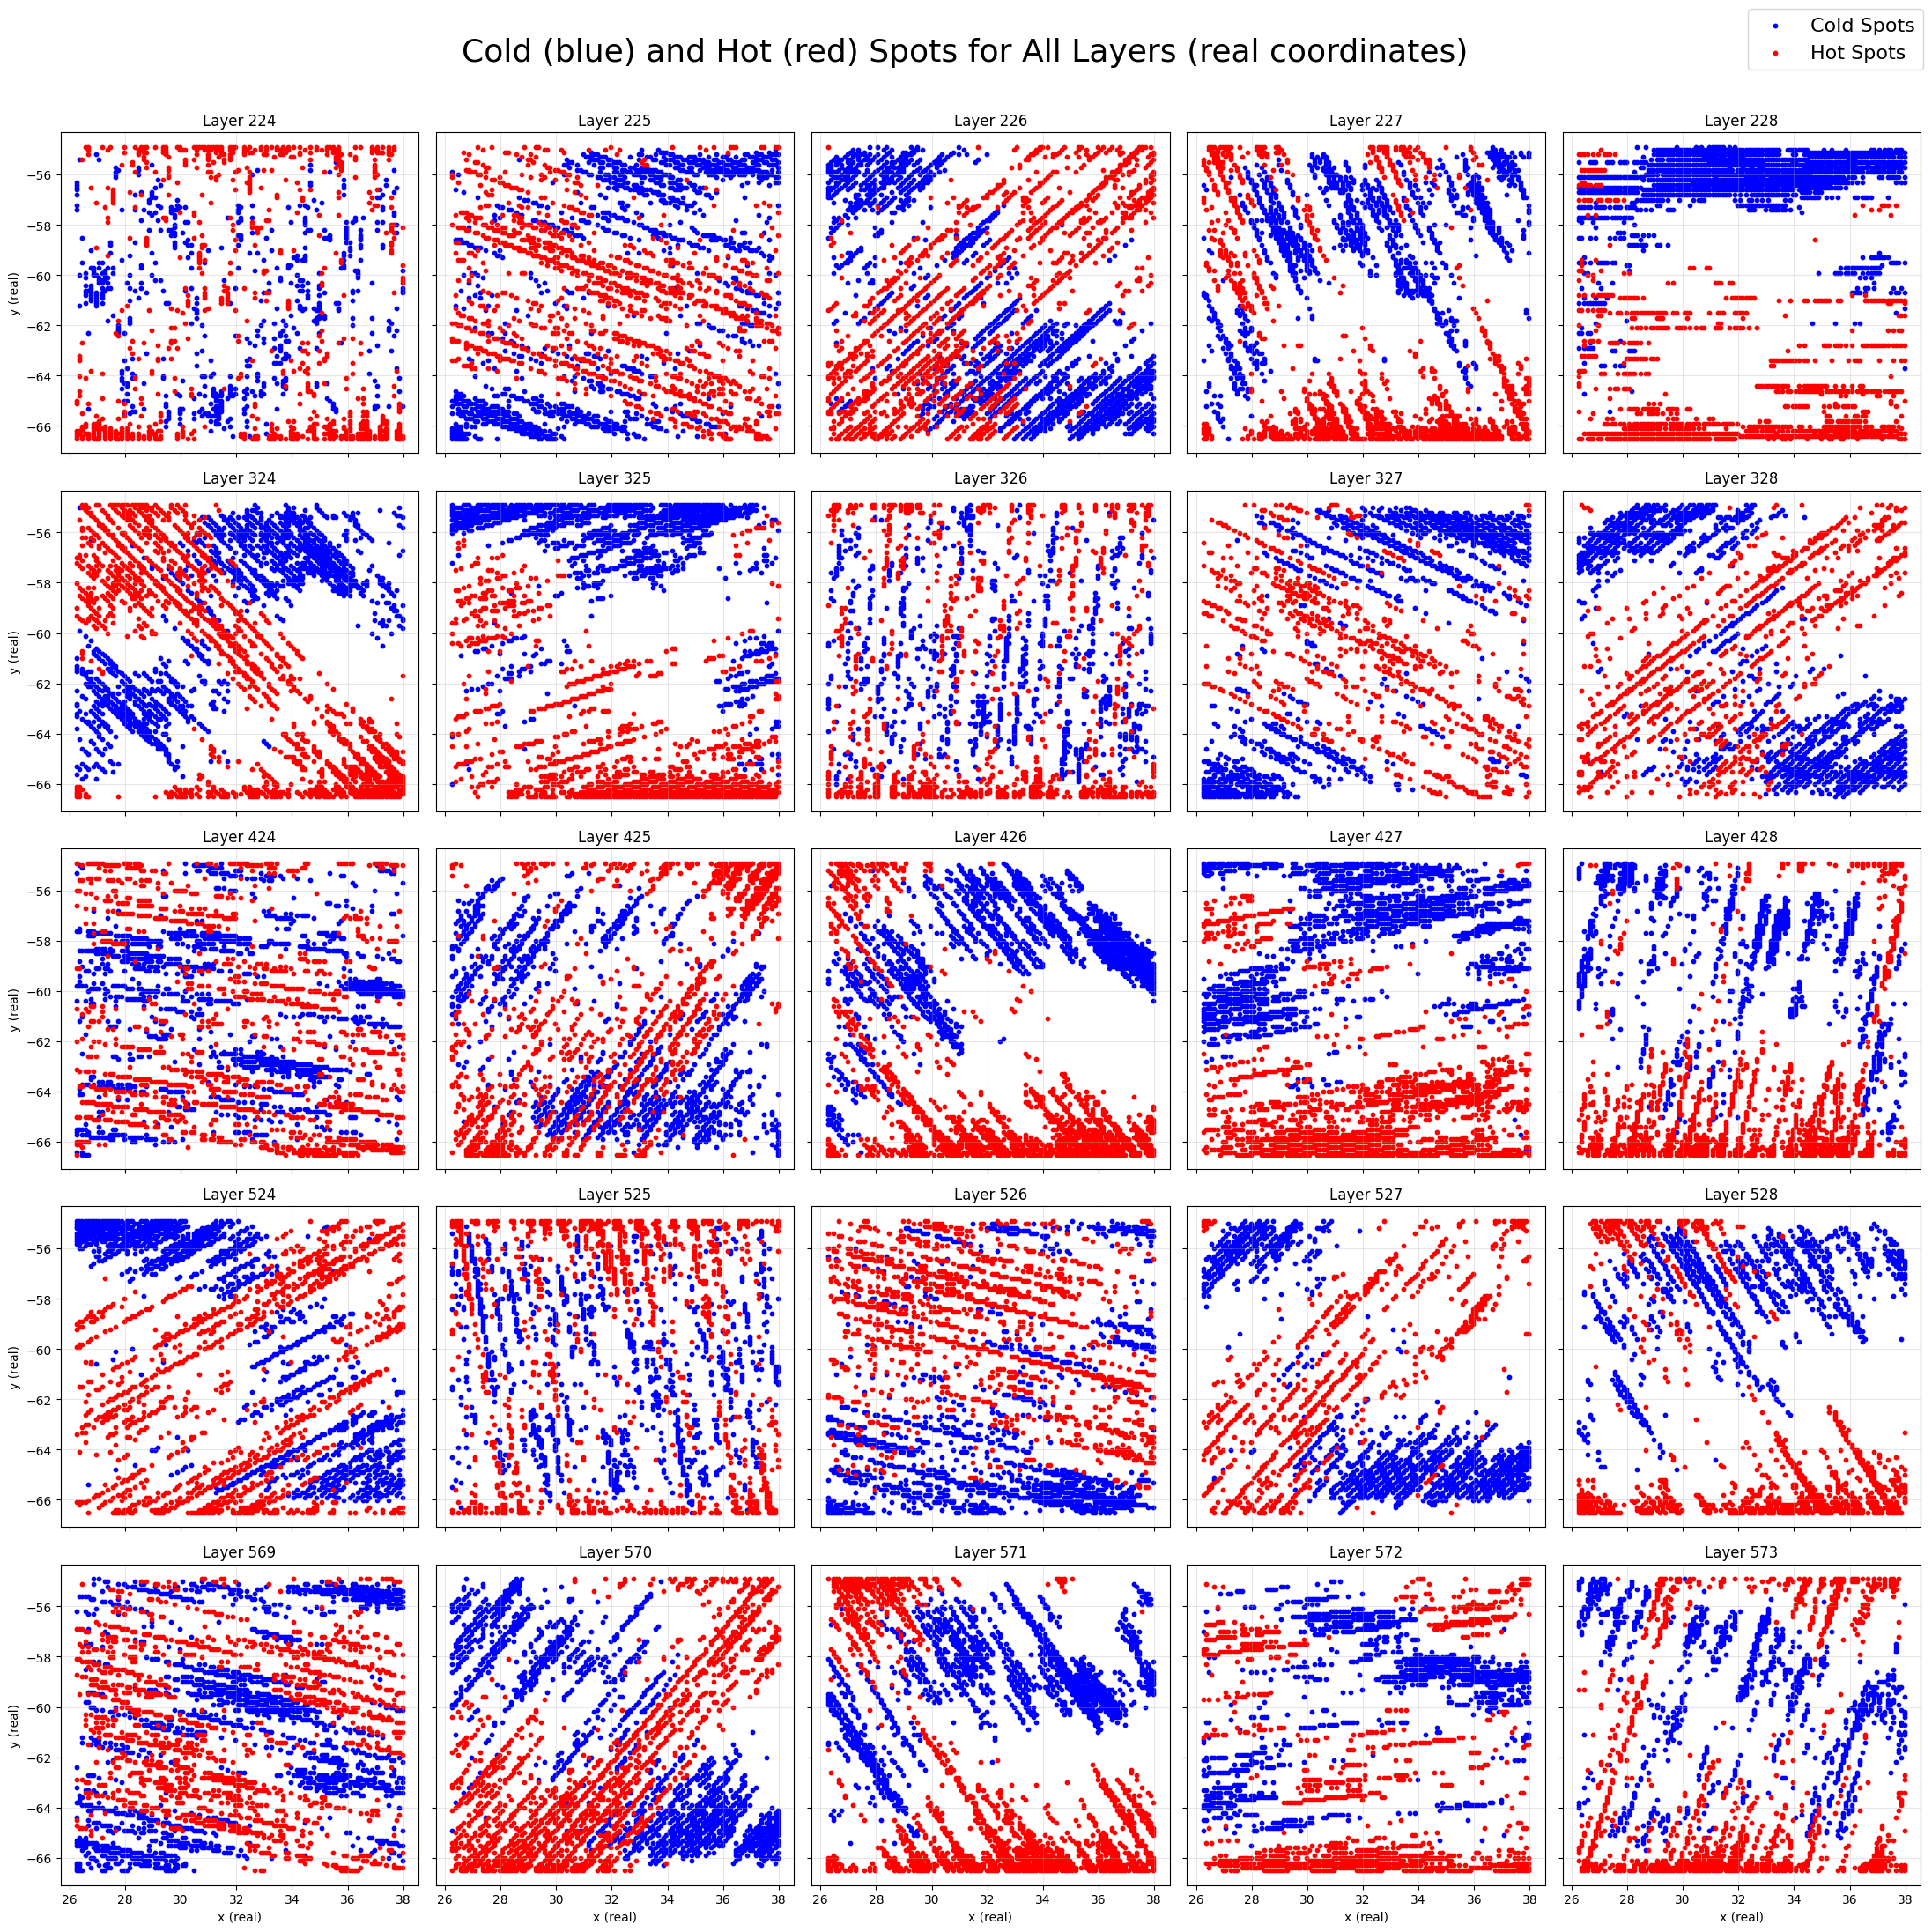

In [ ]:
# Compute real coordinates for the entire cold_spots and hot_spots DataFrames
cold_spots['x_real'] = x_range[0] + cold_spots['x'] * 10**-digits_round
cold_spots['y_real'] = y_range[0] + cold_spots['y'] * 10**-digits_round
hot_spots['x_real'] = x_range[0] + hot_spots['x'] * 10**-digits_round
hot_spots['y_real'] = y_range[0] + hot_spots['y'] * 10**-digits_round

fig, axes = plt.subplots(5, 5, figsize=(22, 22), sharex=True, sharey=True)
axes = axes.flatten()

for idx, lid in enumerate(sorted(layer_ids)):
    # Layer index in cold_spots/hot_spots is 1-based (1 for 224, 2 for 225, ...)
    cold = cold_spots[cold_spots['layer_id'] == idx + 1]
    hot = hot_spots[hot_spots['layer_id'] == idx + 1]

    ax = axes[idx]
    ax.scatter(cold['x_real'], cold['y_real'], color='blue', s=10, label='Cold Spots')
    ax.scatter(hot['x_real'], hot['y_real'], color='red', s=10, label='Hot Spots')
    ax.set_title(f'Layer {lid}')
    ax.grid(True, alpha=0.3)
    if idx % 5 == 0:
        ax.set_ylabel('y (real)')
    if idx >= 20:
        ax.set_xlabel('x (real)')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=16)
fig.suptitle('Cold (blue) and Hot (red) Spots for All Layers (real coordinates)', fontsize=26)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Add a 10x10 grid overlay to each subplot
for ax in axes:
    # Draw vertical grid lines
    for xb in np.linspace(cold_spots['x_real'].min(), cold_spots['x_real'].max(), 11):
        ax.axvline(x=xb, color='gray', linestyle=':', linewidth=1, alpha=0.7)
    # Draw horizontal grid lines
    for yb in np.linspace(cold_spots['y_real'].min(), cold_spots['y_real'].max(), 11):
        ax.axhline(y=yb, color='gray', linestyle=':', linewidth=1, alpha=0.7)

### Da qui metodo dade

An indicator was introduced to identify anomalies inside layers. Each layer was divided into 36 quadrants.

#### Color Balance & Density Indicator

Measures balanced presence and density of red/blue pixels (out of total pixels).

**High:** Near equal red/blue, high total colored pixels.
**Low:** Dominant color OR few total colored pixels.

**Formula:**

$$M = \left( 1 - \frac{|N_b - N_r|}{N_b + N_r + 1} \right) \times \frac{N_b + N_r}{N_{total} + 1}$$

Where $N_b$ = blue pixels, $N_r$ = red pixels, $N_{total}$ = total pixels.

In [8]:
def color_balance_density_metric(num_blue_pixels, num_red_pixels, total_pixels):
  """
  Calculates a metric that is high when blue and red pixels are balanced
  and their density is high.

  Args:
    num_blue_pixels: The number of blue pixels.
    num_red_pixels: The number of red pixels.
    total_pixels: The total number of pixels in the area.

  Returns:
    A float representing the metric value.
  """
  num_colored_pixels = num_blue_pixels + num_red_pixels
  if num_colored_pixels == 0:
    return 0.0

  color_balance = 1 - (abs(num_blue_pixels - num_red_pixels) / (num_colored_pixels + 1))
  density = num_colored_pixels / (total_pixels + 1)

  metric = color_balance * density
  return metric

# Example usage:
num_blue = 70
num_red = 70
total = 144
metric_value = color_balance_density_metric(num_blue, num_red, total)
print("Example usages:")
print(f"Metric value: {metric_value}")

num_blue = 130
num_red = 10
total = 144
metric_value = color_balance_density_metric(num_blue, num_red, total)
print(f"Metric value: {metric_value}")

num_blue = 10
num_red = 10
total = 144
metric_value = color_balance_density_metric(num_blue, num_red, total)
print(f"Metric value: {metric_value}")

Example usages:
Metric value: 0.9655172413793104
Metric value: 0.1438004402054292
Metric value: 0.13793103448275862


The data was divided into a 6x6 grid and $M$ was calulated for each region.

In [9]:
# Divide into 6x6 grid using pd.cut with 6 bins for x and y
cold_spots['x_bin'] = pd.cut(cold_spots['x'], bins=6, labels=False, include_lowest=True)
cold_spots['y_bin'] = pd.cut(cold_spots['y'], bins=6, labels=False, include_lowest=True)
hot_spots['x_bin'] = pd.cut(hot_spots['x'], bins=6, labels=False, include_lowest=True)
hot_spots['y_bin'] = pd.cut(hot_spots['y'], bins=6, labels=False, include_lowest=True)

# Compute area_id as a unique identifier for each grid cell
cold_spots['grid_area'] = (cold_spots['y_bin'] * 6 + cold_spots['x_bin']).astype(int)
hot_spots['grid_area'] = (hot_spots['y_bin'] * 6 + hot_spots['x_bin']).astype(int)

# Calculate the metric for each grid area within each layer
layer_metrics = []
for layer in sorted(cold_spots['layer_id'].unique()):
    cold_layer = cold_spots[cold_spots['layer_id'] == layer]
    hot_layer = hot_spots[hot_spots['layer_id'] == layer]
    for area_id in range(6 * 6):
        num_blue = (cold_layer['grid_area'] == area_id).sum()
        num_red = (hot_layer['grid_area'] == area_id).sum()
        metric = color_balance_density_metric(num_blue, num_red, 100)
        layer_metrics.append({
            'layer_id': layer,
            'area_id': area_id,
            'num_blue': num_blue,
            'num_red': num_red,
            'metric': metric
        })

layer_grid_metrics = pd.DataFrame(layer_metrics)
layer_grid_metrics.head()

layer_id  area_id  num_blue  num_red    metric
0         1        0         6       76  0.127162
1         1        1        21       40  0.418876
2         1        2        57        7  0.146230
3         1        3        19       41  0.379808
4         1        4         7       58  0.146265

In [22]:
# Divide into 10x10 grid using pd.cut with 10 bins for x and y
cold_spots['x_bin'] = pd.cut(cold_spots['x'], bins=10, labels=False, include_lowest=True)
cold_spots['y_bin'] = pd.cut(cold_spots['y'], bins=10, labels=False, include_lowest=True)
hot_spots['x_bin'] = pd.cut(hot_spots['x'], bins=10, labels=False, include_lowest=True)
hot_spots['y_bin'] = pd.cut(hot_spots['y'], bins=10, labels=False, include_lowest=True)

# Compute area_id as a unique identifier for each grid cell
cold_spots['grid_area'] = (cold_spots['y_bin'] * 10 + cold_spots['x_bin']).astype(int)
hot_spots['grid_area'] = (hot_spots['y_bin'] * 10 + hot_spots['x_bin']).astype(int)

# Calculate the metric for each grid area within each layer
layer_metrics = []
for layer in sorted(cold_spots['layer_id'].unique()):
    cold_layer = cold_spots[cold_spots['layer_id'] == layer]
    hot_layer = hot_spots[hot_spots['layer_id'] == layer]
    for area_id in range(10 * 10):
        num_blue = (cold_layer['grid_area'] == area_id).sum()
        num_red = (hot_layer['grid_area'] == area_id).sum()
        metric = color_balance_density_metric(num_blue, num_red, 70)
        layer_metrics.append({
            'layer_id': layer,
            'area_id': area_id,
            'num_blue': num_blue,
            'num_red': num_red,
            'metric': metric
        })

layer_grid_metrics = pd.DataFrame(layer_metrics)
layer_grid_metrics.head()

layer_id  area_id  num_blue  num_red    metric
0         1        0         0       43  0.013764
1         1        1         4       33  0.123425
2         1        2         6       21  0.176559
3         1        3         9       12  0.255442
4         1        4        20        0  0.013414

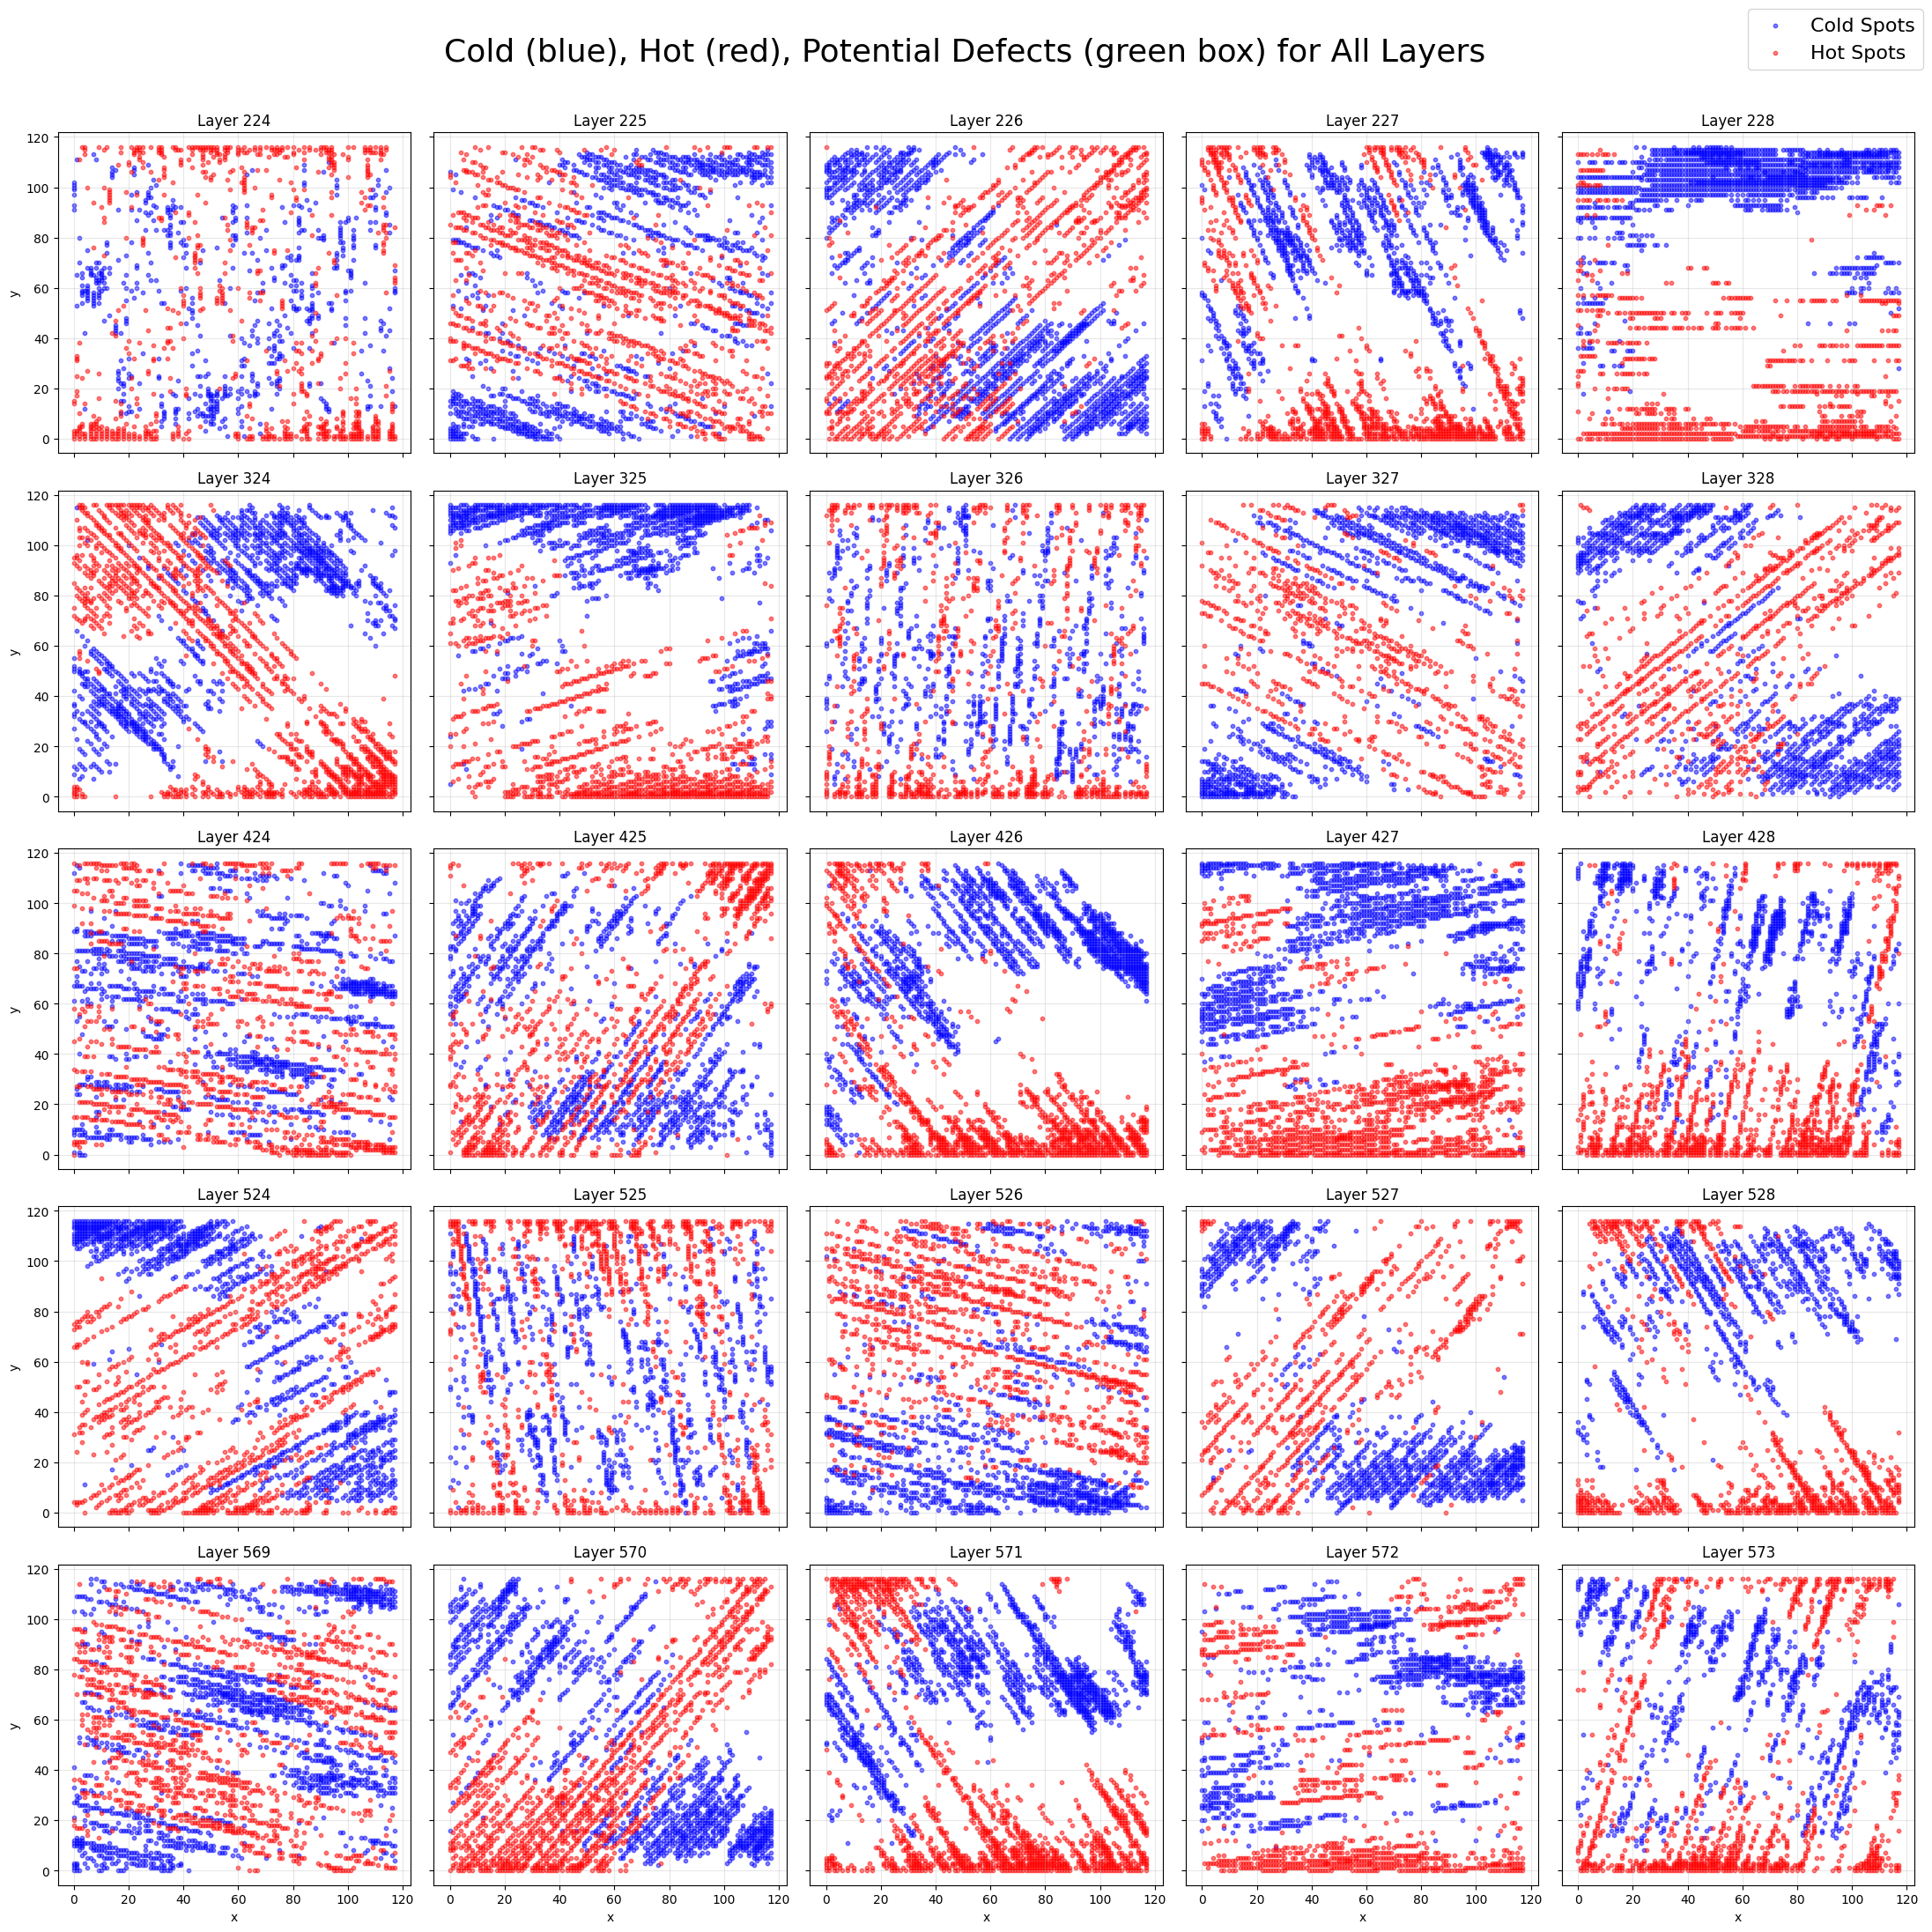

In [20]:
# Graphical representation of regions with high M
fig, axes = plt.subplots(5, 5, figsize=(22, 22), sharex=True, sharey=True)
axes = axes.flatten()

for i, lid in enumerate(sorted(layer_ids)):
    # Filter metrics, cold_spots, and hot_spots for this layer
    layer_metric = layer_grid_metrics[layer_grid_metrics['layer_id'] == i + 1]
    cold_spots_layer = cold_spots[cold_spots['layer_id'] == i + 1]
    hot_spots_layer = hot_spots[hot_spots['layer_id'] == i + 1]

    ax = axes[i]
    ax.scatter(cold_spots_layer['x'], cold_spots_layer['y'], color='blue', s=10, alpha=0.5, label='Cold Spots')
    ax.scatter(hot_spots_layer['x'], hot_spots_layer['y'], color='red', s=10, alpha=0.5, label='Hot Spots')

    # Mark grid cells where metric > 0.5
    highlight_areas = layer_metric[layer_metric['metric'] > 0.5]['area_id'].values
    for area_id in highlight_areas:
        y_bin = area_id // 6
        x_bin = area_id % 6
        x0 = cold_spots_layer['x'].min() + (cold_spots_layer['x'].max() - cold_spots_layer['x'].min()) * x_bin / 6
        x1 = cold_spots_layer['x'].min() + (cold_spots_layer['x'].max() - cold_spots_layer['x'].min()) * (x_bin + 1) / 6
        y0 = cold_spots_layer['y'].min() + (cold_spots_layer['y'].max() - cold_spots_layer['y'].min()) * y_bin / 6
        y1 = cold_spots_layer['y'].min() + (cold_spots_layer['y'].max() - cold_spots_layer['y'].min()) * (y_bin + 1) / 6
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor='green', linewidth=5))

    ax.set_title(f'Layer {lid}')
    ax.grid(True, alpha=0.3)
    if i % 5 == 0:
        ax.set_ylabel('y')
    if i >= 20:
        ax.set_xlabel('x')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=16)
fig.suptitle('Cold (blue), Hot (red), Potential Defects (green box) for All Layers', fontsize=26)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

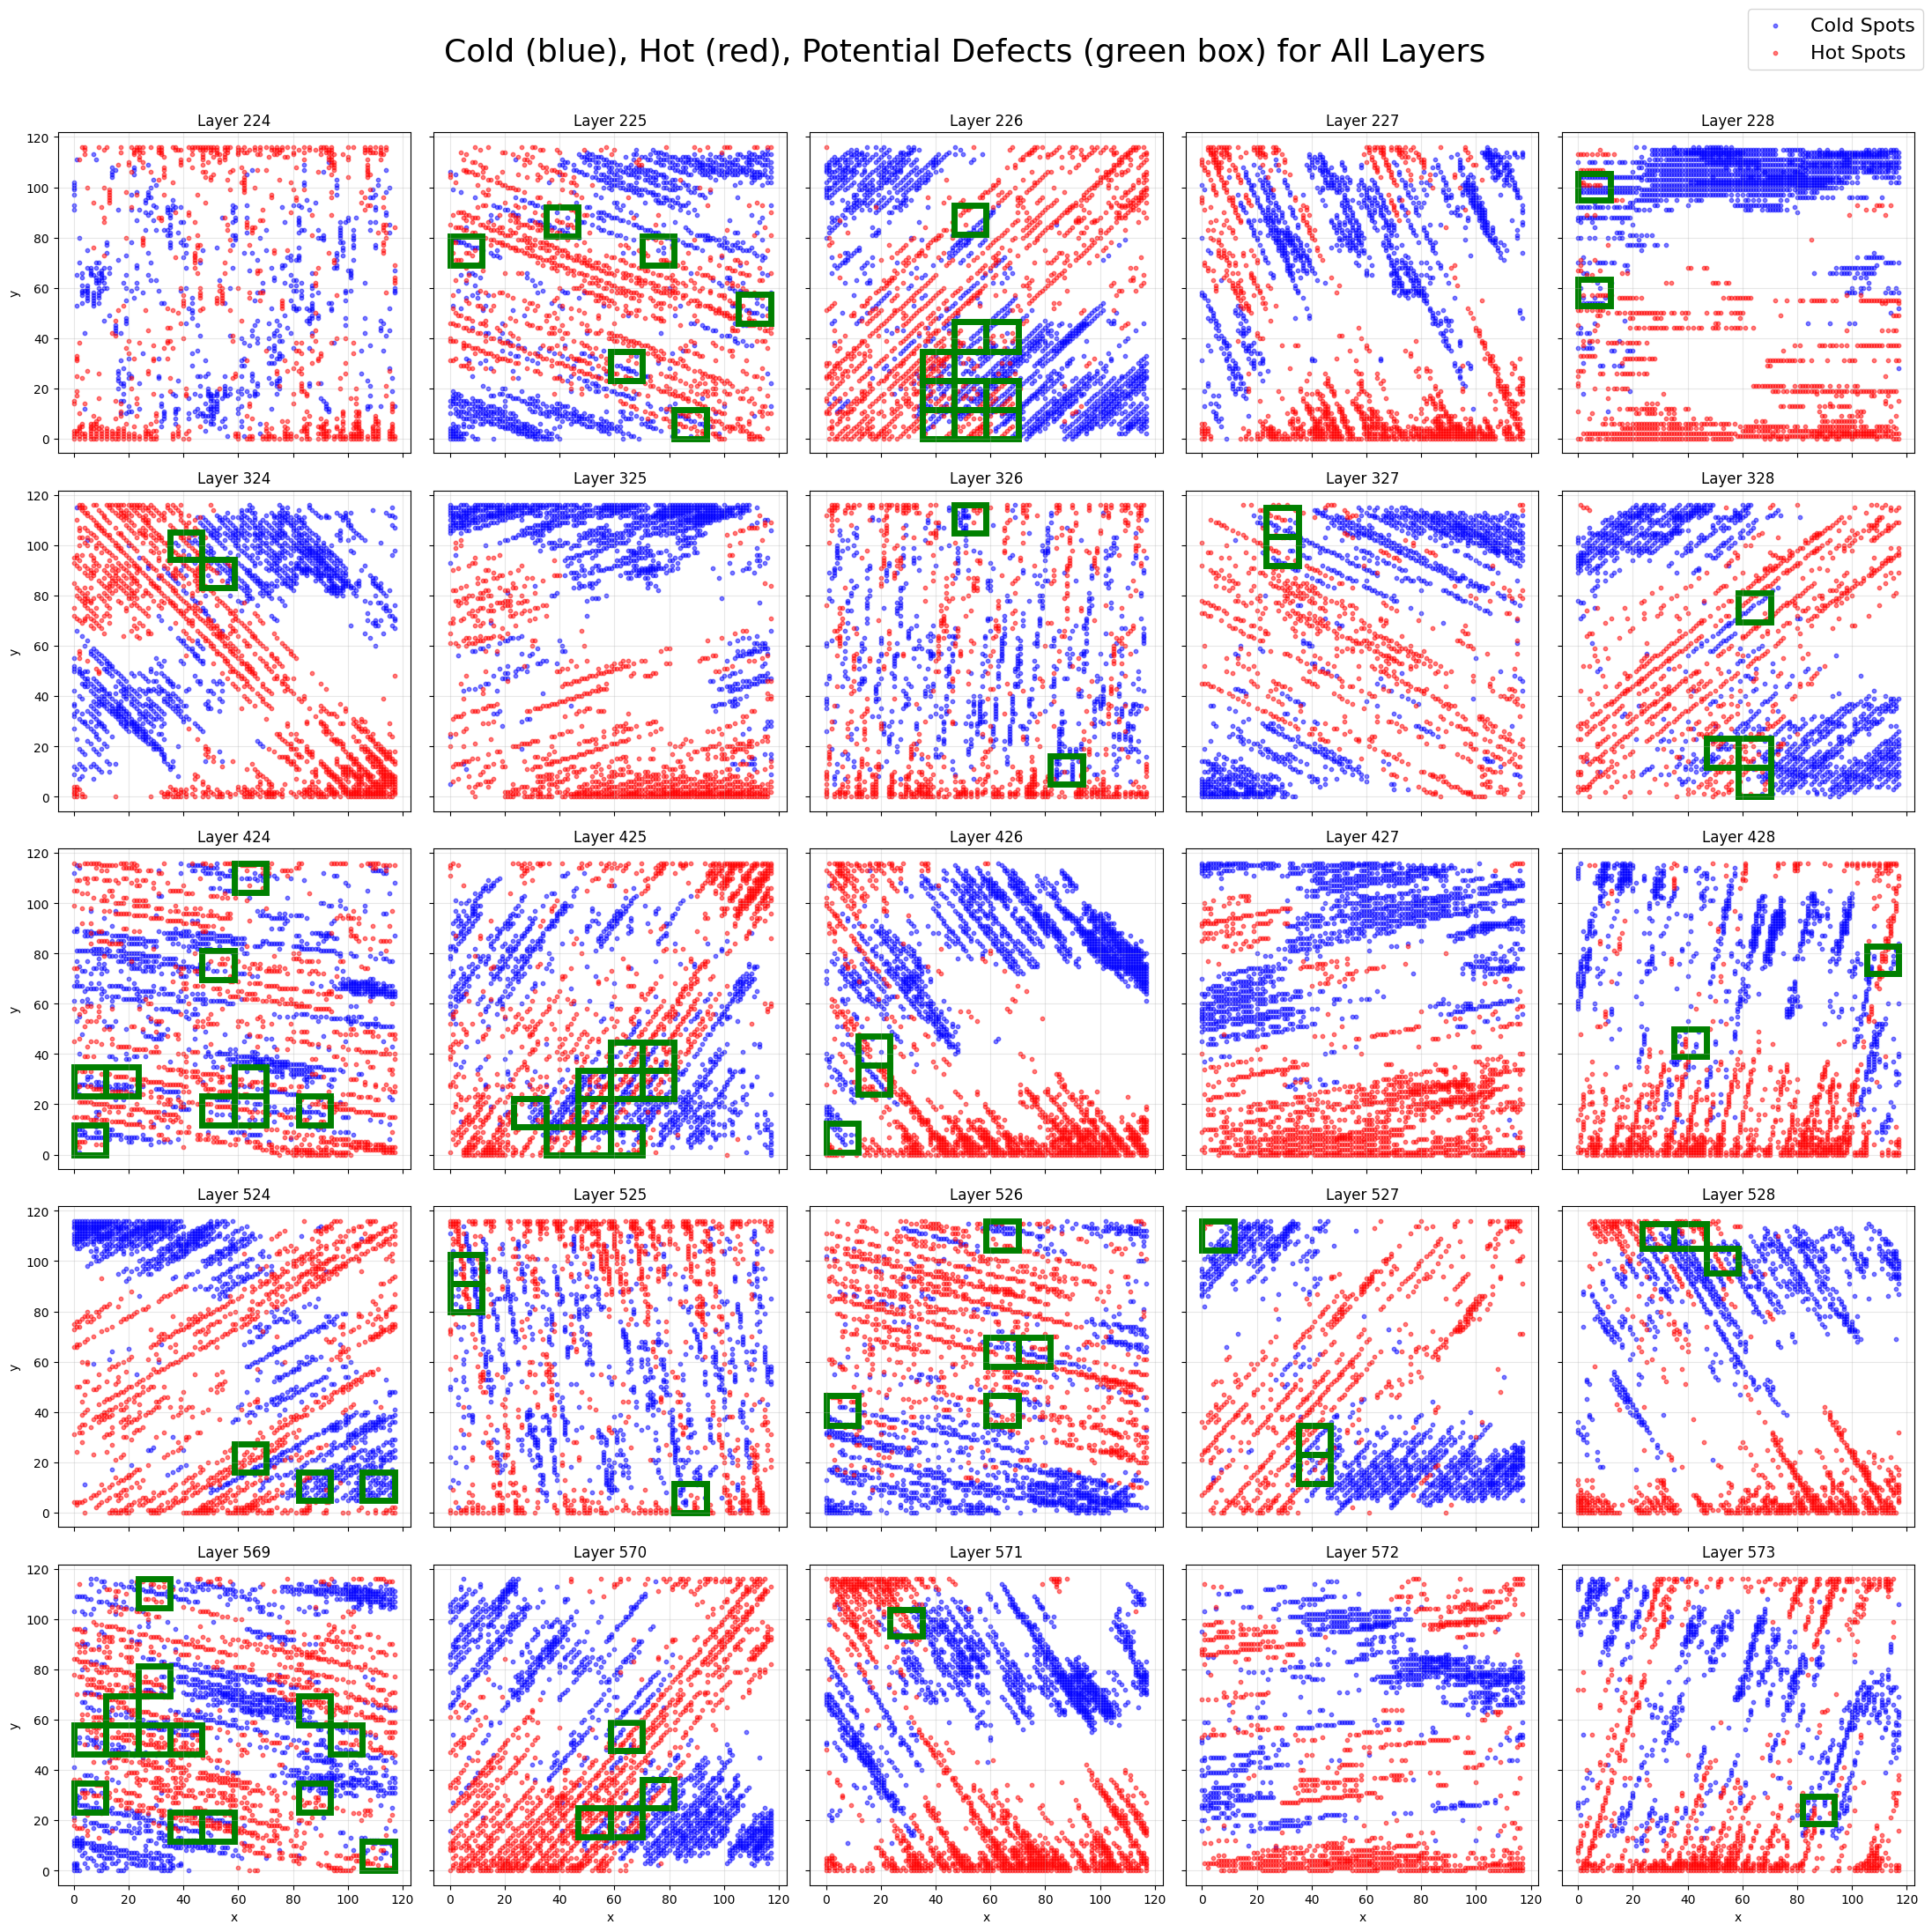

In [24]:
# Graphical representation of regions with high M
fig, axes = plt.subplots(5, 5, figsize=(22, 22), sharex=True, sharey=True)
axes = axes.flatten()

for i, lid in enumerate(sorted(layer_ids)):
    # Filter metrics, cold_spots, and hot_spots for this layer
    layer_metric = layer_grid_metrics[layer_grid_metrics['layer_id'] == i + 1]
    cold_spots_layer = cold_spots[cold_spots['layer_id'] == i + 1]
    hot_spots_layer = hot_spots[hot_spots['layer_id'] == i + 1]

    ax = axes[i]
    ax.scatter(cold_spots_layer['x'], cold_spots_layer['y'], color='blue', s=10, alpha=0.5, label='Cold Spots')
    ax.scatter(hot_spots_layer['x'], hot_spots_layer['y'], color='red', s=10, alpha=0.5, label='Hot Spots')

    # Mark grid cells where metric > 0.3
    highlight_areas = layer_metric[layer_metric['metric'] > 0.3]['area_id'].values
    for area_id in highlight_areas:
        y_bin = area_id // 10
        x_bin = area_id % 10
        x0 = cold_spots_layer['x'].min() + (cold_spots_layer['x'].max() - cold_spots_layer['x'].min()) * x_bin / 10
        x1 = cold_spots_layer['x'].min() + (cold_spots_layer['x'].max() - cold_spots_layer['x'].min()) * (x_bin + 1) / 10
        y0 = cold_spots_layer['y'].min() + (cold_spots_layer['y'].max() - cold_spots_layer['y'].min()) * y_bin / 10
        y1 = cold_spots_layer['y'].min() + (cold_spots_layer['y'].max() - cold_spots_layer['y'].min()) * (y_bin + 1) / 10
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor='green', linewidth=5))

    ax.set_title(f'Layer {lid}')
    ax.grid(True, alpha=0.3)
    if i % 5 == 0:
        ax.set_ylabel('y')
    if i >= 20:
        ax.set_xlabel('x')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=16)
fig.suptitle('Cold (blue), Hot (red), Potential Defects (green box) for All Layers', fontsize=26)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

> Regions with potential anomalies are highlighted in green. These were selected with a threshold of $M > 0.5$ that was found empirically found.

Runs test statistic = -1.361
Runs test p-value = 0.174



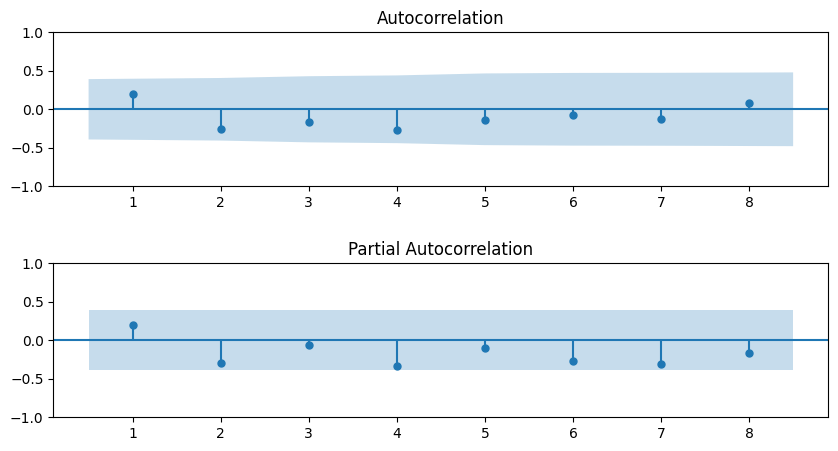

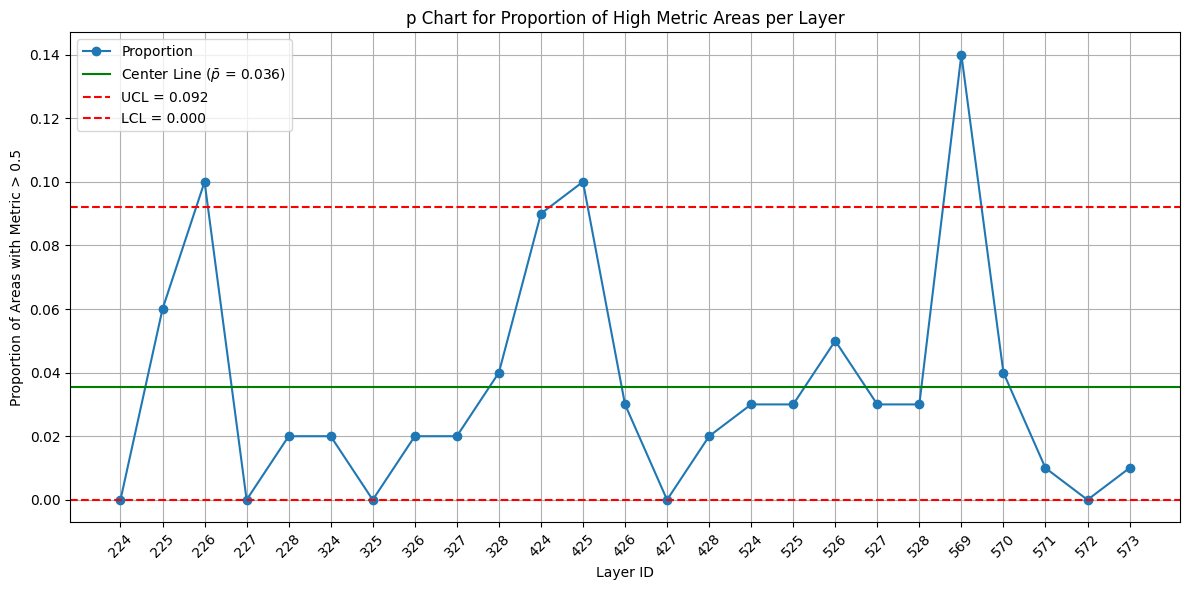

Layers with out-of-control proportions (real layer IDs):
Layer 226 (index 3) - Proportion: 0.100
Layer 425 (index 12) - Proportion: 0.100
Layer 569 (index 21) - Proportion: 0.140


In [27]:
from statsmodels.stats.proportion import proportion_confint

# Calculate the proportion of "successes" for each grid area (e.g., metric > threshold)
n = 100
threshold = 0.3
layer_grid_metrics['is_success'] = (layer_grid_metrics['metric'] > threshold).astype(int)

# Group by layer and calculate the proportion of successes per layer
p_chart_data = layer_grid_metrics.groupby('layer_id')['is_success'].mean()
 
_=qda.Assumptions(p_chart_data).independence()  # Controllo di indipendenza

# Calculate control limits for each layer
p_bar = p_chart_data.mean()
ucl = p_bar + 3 * np.sqrt(p_bar / n)
lcl = p_bar - 3 * np.sqrt(p_bar / n)
lcl = max(lcl, 0)  # LCL cannot be negative



plt.figure(figsize=(12, 6))
plt.plot(p_chart_data.index, p_chart_data.values, marker='o', linestyle='-', label='Proportion')
ax = plt.gca()
ax.set_xticks(p_chart_data.index)
ax.set_xticklabels([layer_ids[i - 1] for i in p_chart_data.index], rotation=45)
plt.xlabel('Real Layer ID')
plt.axhline(p_bar, color='green', linestyle='-', label=f'Center Line ($\\bar{{p}}$ = {p_bar:.3f})')
plt.axhline(ucl, color='red', linestyle='--', label=f'UCL = {ucl:.3f}')
plt.axhline(lcl, color='red', linestyle='--', label=f'LCL = {lcl:.3f}')
plt.xlabel('Layer ID')
plt.ylabel('Proportion of Areas with Metric > 0.5')
plt.title('p Chart for Proportion of High Metric Areas per Layer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Annotate out-of-control points with their real layer IDs
out_of_control_layers = p_chart_data[(p_chart_data > ucl) | (p_chart_data < lcl)].index.tolist()
if out_of_control_layers:
    print("Layers with out-of-control proportions (real layer IDs):")
    for idx in out_of_control_layers:
        real_layer_id = layer_ids[idx - 1]  # idx is 1-based, layer_ids is sorted real IDs
        print(f"Layer {real_layer_id} (index {idx}) - Proportion: {p_chart_data.loc[idx]:.3f}")
else:
    print("No out-of-control layers found.")

### Da qui metodo che torna (linda)

To enable spatial comparison, both the cold spot and hot spot datasets were divided into 10 spatial areas. The division was carried out in a way that ensured each area contained approximately the same number of points, allowing for a balanced representation across the spatial domain. Consistent area boundaries were applied to both datasets to ensure comparability in subsequent analyses.

In [ ]:
x_area_cs, x_bins_cs = pd.qcut(cold_spots['x'], q=10, labels=False, retbins=True, duplicates='drop')
y_area_cs, y_bins_cs = pd.qcut(cold_spots['y'], q=10, labels=False, retbins=True, duplicates='drop')

# Calcola area_id (1-25) secondo la posizione nella griglia 5x5
cold_spots['area_id'] = (y_area_cs * 10 + x_area_cs + 1).astype(int)

# Suddividi x e y in 5 intervalli ciascuno (5x5=25 aree) con lo stesso numero di punti per area
x_area_hs = pd.cut(hot_spots['x'], bins=x_bins_cs, labels=False, include_lowest=True)
y_area_hs = pd.cut(hot_spots['y'], bins=y_bins_cs, labels=False, include_lowest=True)
hot_spots['area_id'] = (y_area_hs * 10 + x_area_hs + 1).astype(int)



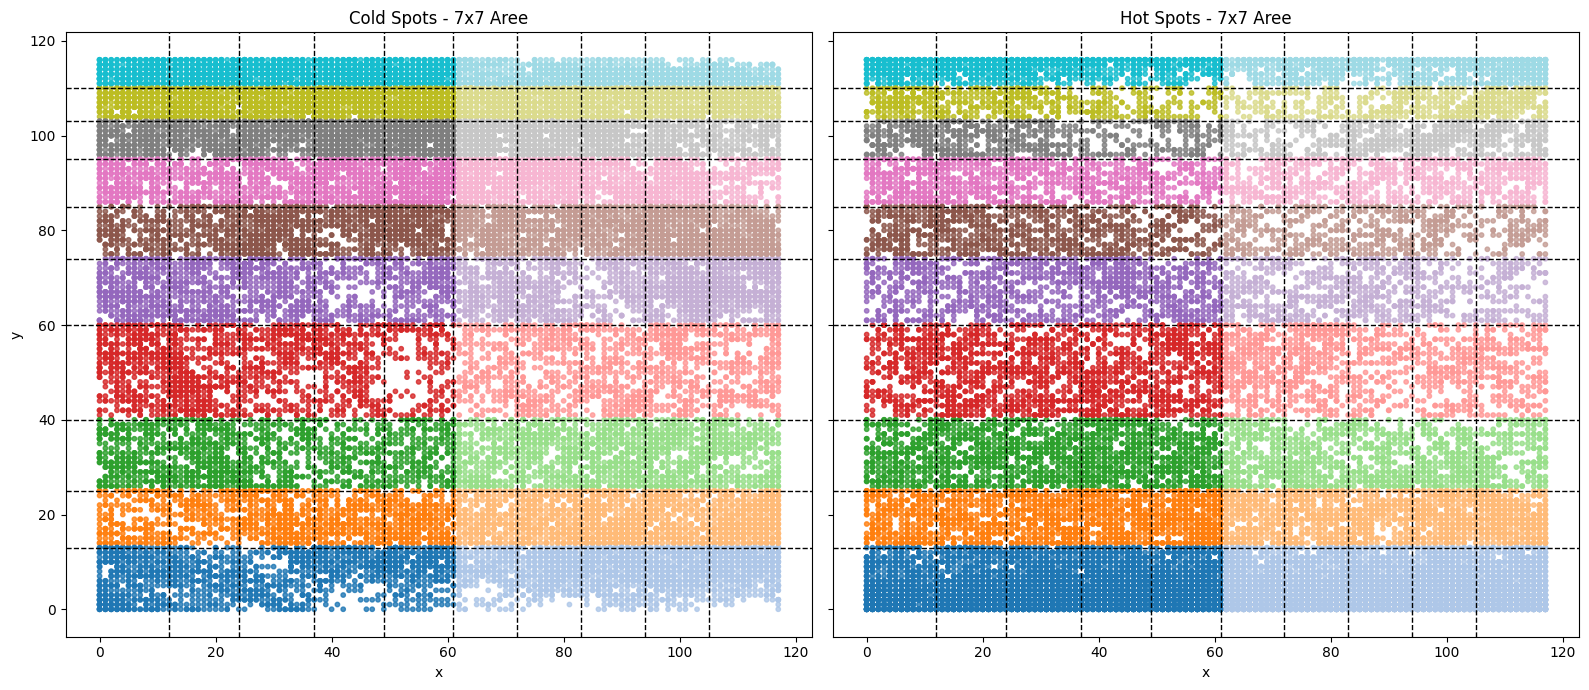

In [9]:
# Plot delle aree per cold_spots e hot_spots (7x7 aree)

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Cold spots
axes[0].scatter(
    cold_spots['x'], cold_spots['y'],
    c=cold_spots['area_id'], cmap='tab20', s=10, alpha=0.8
)
axes[0].set_title('Cold Spots - 7x7 Aree')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
for xb in x_bins_cs[1:-1]:
    axes[0].axvline(x=xb, color='k', linestyle='--', linewidth=1)
for yb in y_bins_cs[1:-1]:
    axes[0].axhline(y=yb, color='k', linestyle='--', linewidth=1)

# Hot spots
axes[1].scatter(
    hot_spots['x'], hot_spots['y'],
    c=hot_spots['area_id'], cmap='tab20', s=10, alpha=0.8
)
axes[1].set_title('Hot Spots - 7x7 Aree')
axes[1].set_xlabel('x')
for xb in x_bins_cs[1:-1]:
    axes[1].axvline(x=xb, color='k', linestyle='--', linewidth=1)
for yb in y_bins_cs[1:-1]:
    axes[1].axhline(y=yb, color='k', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

For each spatial area and each layer, the average standardized temperature (temp_std) was computed separately for cold and hot spots. Subsequently, the difference between the hot spot and cold spot averages was calculated for each area and layer, treating the cold spot values in absolute terms. This approach enabled a direct comparison of thermal intensity between hot and cold zones across spatial regions and vertical layers.

Cold spot values were converted to their absolute form in order to ensure that temperature deviations were treated symmetrically with respect to intensity, regardless of direction. This transformation allows for a direct comparison between the magnitude of hot and cold anomalies, focusing on the strength of the deviation rather than its sign. As a result, the computed differences reflect contrasts in thermal intensity, rather than merely directional differences in temperature variation.

In [10]:
# Media dei punti cold per ogni area e layer
mean_cold_per_area_layer = cold_spots.groupby(['area_id', 'layer_id'])['temp_std'].mean().unstack()

# Media dei punti hot per ogni area e layer
mean_hot_per_area_layer = hot_spots.groupby(['area_id', 'layer_id'])['temp_std'].mean().unstack()

print("Media cold per area e layer:")
print(mean_cold_per_area_layer)
print("Media hot per area e layer:")
print(mean_hot_per_area_layer)

# Calcola la differenza tra le medie hot e cold per ogni area_id e layer_id
diff_hot_cold_per_area_layer = mean_hot_per_area_layer - (- mean_cold_per_area_layer)
print("Differenza hot-cold per area e layer:")
print(diff_hot_cold_per_area_layer)

Media cold per area e layer:
layer_id        1         2         3         4         5         6   \
area_id                                                                
1        -1.776948 -1.949563 -1.732029 -1.785528 -1.656674 -1.691475   
2        -2.234156 -2.070980       NaN -1.710288       NaN -1.449210   
3        -1.969032 -1.958546 -1.705947       NaN       NaN -1.455630   
4        -2.067841 -1.849163 -1.770814       NaN       NaN -1.453546   
5        -2.000201 -1.796569 -1.722514       NaN       NaN       NaN   
...            ...       ...       ...       ...       ...       ...   
96             NaN -1.689538       NaN       NaN -1.855822 -1.660549   
97             NaN -1.958346       NaN       NaN -1.774505 -1.622326   
98             NaN -2.225805       NaN -1.509399 -1.858976 -1.636402   
99             NaN -1.944647       NaN -2.031617 -1.952522 -1.548249   
100            NaN -2.250773       NaN -1.824742 -1.852597 -1.512658   

layer_id        7         8       

To assess the normality of the computed hot–cold differences across spatial areas and layers, a Box-Cox transformation was applied. Since the Box-Cox method requires strictly positive values, the data were shifted accordingly to ensure all values exceeded zero. The transformation was performed on the flattened array of difference values, excluding missing entries. 

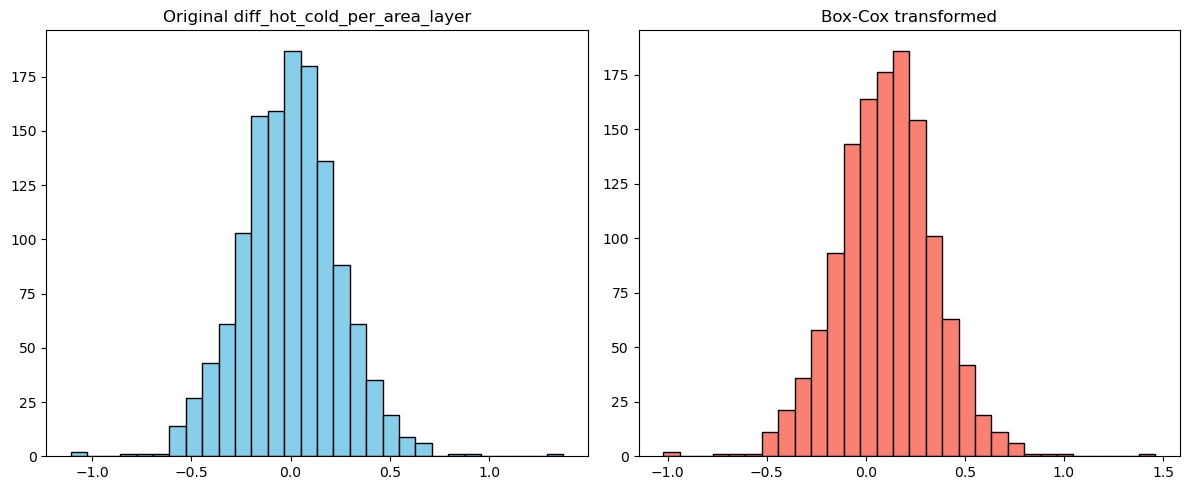

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


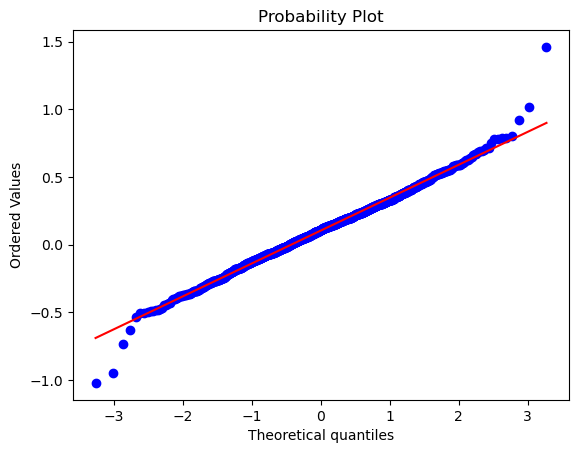

Shapiro-wilk test statistic = 0.992
Shapiro-wilk test p-value = 0.000


In [173]:
from scipy.stats import boxcox

# Appiattisci i valori in una serie 1D, ignorando eventuali NaN
diff_values = diff_hot_cold_per_area_layer.values.flatten()
diff_values = diff_values[~np.isnan(diff_values)]

# Box-Cox richiede valori > 0, quindi shift se necessario
min_val = diff_values.min()
if min_val <= 0:
    shift = abs(min_val) + 1e-6
else:
    shift = 0

diff_shifted = diff_values + shift
diff_boxcox, fitted_lambda = boxcox(diff_shifted)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(diff_values, bins=30, color='skyblue', edgecolor='k')
plt.title('Original diff_hot_cold_per_area_layer')
plt.subplot(1,2,2)
plt.hist(diff_boxcox, bins=30, color='salmon', edgecolor='k')
plt.title('Box-Cox transformed')
plt.tight_layout()
plt.show()

_ = qda.Assumptions(diff_boxcox).normality()  

> Following the Box-Cox transformation, the distribution of the hot–cold difference values appeared approximately normal. The Q–Q plot showed that the majority of data points aligned well along the theoretical quantile line, indicating an overall good fit to the normal distribution. However, some deviations were observed in the tails, where a number of points diverged from the reference line, suggesting the presence of mild outliers or heavier tails than expected under perfect normality. Despite these tail deviations, the distribution was considered sufficiently normal for the purposes of subsequent analyses, as the central assumptions of normality were met for the bulk of the data.

To monitor the stability and variability of the hot–cold temperature differences across spatial areas and layers, an Individuals and Moving Range (I-MR) control chart was applied. The matrix of differences was first flattened into a one-dimensional series to meet the input requirements of the control chart procedure. 

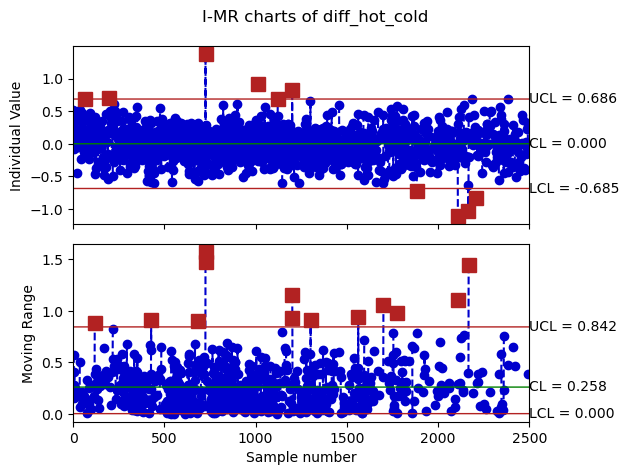

In [174]:
# diff_hot_cold_per_area_layer è una DataFrame (area_id x layer_id) con le differenze hot-cold le differenze hot-cold le differenze hot-
# Per la carta I-MR, serve una serie "long" di valori

diff_hot_cold_values = diff_hot_cold_per_area_layer.values.flatten()


df_diff_hot_cold_long = pd.DataFrame(diff_hot_cold_values, columns=['diff_hot_cold'])
_ = qda.ControlCharts.IMR(df_diff_hot_cold_long, 'diff_hot_cold')

The I-MR control chart identified a small proportion of out-of-control points, with approximately 0.77% of points flagged in the Individuals chart and 1.01% in the Moving Range chart. These findings suggest that the majority of the hot–cold difference values remain stable, with only a limited number of observations exhibiting unusual variability or shifts.

In [175]:
import numpy as np

# Appiattisci la matrice e salva anche la posizione flat originale
flat_values = diff_hot_cold_per_area_layer.values.flatten()
# Trova gli indici dei valori non NaN
not_nan_mask = ~np.isnan(flat_values)
not_nan_values = flat_values[not_nan_mask]
not_nan_indices = np.where(not_nan_mask)[0]

# Calcola i limiti della carta I-MR solo sui valori non NaN
mean = np.mean(not_nan_values)
mr = np.mean(np.abs(np.diff(not_nan_values)))
d2 = 1.128  # per n=2
UCL = mean + 3 * (mr / d2)
LCL = mean - 3 * (mr / d2)

# Trova gli indici OOC rispetto all'array filtrato
ooc_mask = (not_nan_values > UCL) | (not_nan_values < LCL)
ooc_flat_indices = not_nan_indices[ooc_mask]

# Recupera area_id e layer_id per ogni valore OOC
n_areas, n_layers = diff_hot_cold_per_area_layer.shape
area_ids = diff_hot_cold_per_area_layer.index.values
layer_ids = diff_hot_cold_per_area_layer.columns.values

for idx in ooc_flat_indices:
    area_idx, layer_idx = np.unravel_index(idx, (n_areas, n_layers))
    area_id = area_ids[area_idx]
    layer_id = layer_ids[layer_idx]
    value = diff_hot_cold_per_area_layer.iloc[area_idx, layer_idx]
    print(f"Valore fuori controllo: {value:.3f} (area_id={area_id}, layer_id={layer_id})")

Valore fuori controllo: 1.371 (area_id=30, layer_id=1)
Valore fuori controllo: 0.921 (area_id=41, layer_id=15)
Valore fuori controllo: 0.824 (area_id=49, layer_id=1)
Valore fuori controllo: -0.730 (area_id=76, layer_id=9)
Valore fuori controllo: -1.106 (area_id=85, layer_id=9)
Valore fuori controllo: -1.036 (area_id=87, layer_id=17)
Valore fuori controllo: -0.833 (area_id=89, layer_id=7)


In [176]:
# Conta il numero di punti non NaN nel DataFrame diff_hot_cold_per_area_layer
num_non_nan = diff_hot_cold_per_area_layer.count().sum()
print(f"Numero di punti diversi da NaN in diff_hot_cold_per_area_layer: {num_non_nan}")

Numero di punti diversi da NaN in diff_hot_cold_per_area_layer: 1293


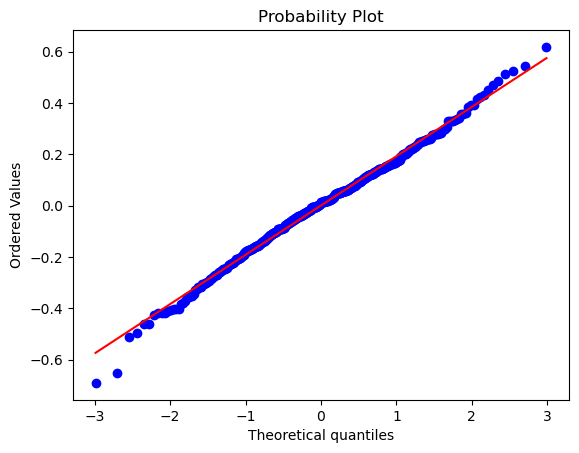

Shapiro-wilk test statistic = 0.995
Shapiro-wilk test p-value = 0.133
Runs test statistic = 0.432
Runs test p-value = 0.666



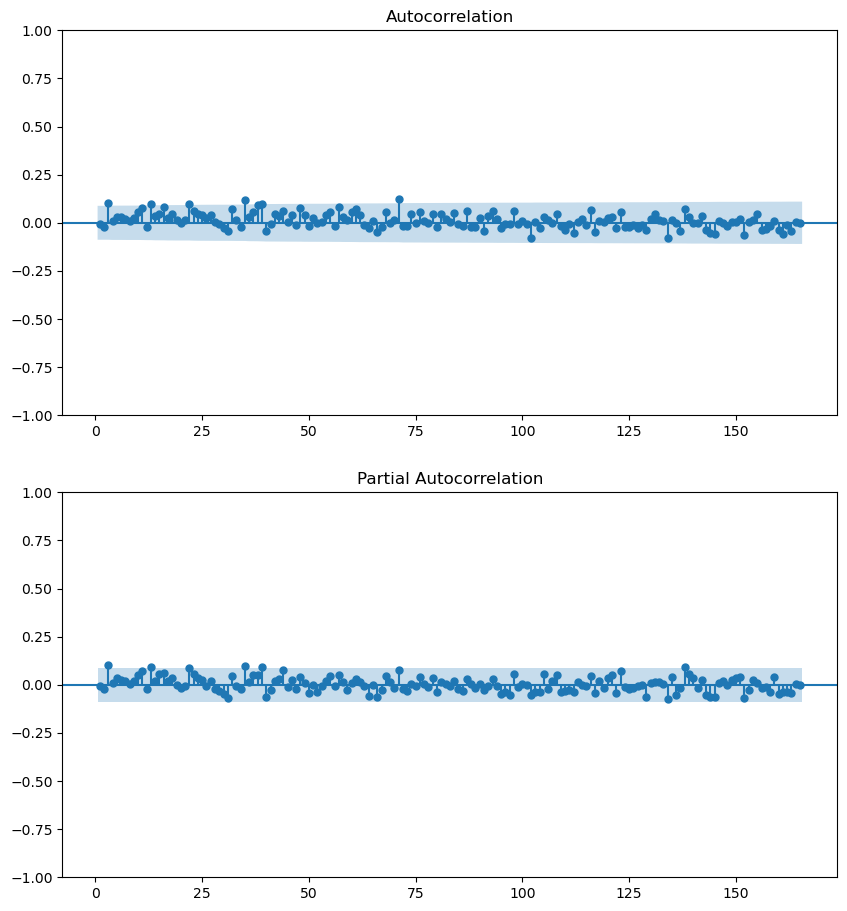

In [166]:
_=qda.Assumptions(df_diff_hot_cold_long['diff_hot_cold']).normality()  # Controllo di normalità   
_=qda.Assumptions(df_diff_hot_cold_long['diff_hot_cold']).independence()  # Controllo di indipendenza